In [1]:
!pip install torch
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 51.2 MB/s eta 0:00:00


In [2]:
import os
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import seed_everything

In [3]:
class ConvModule(nn.Module):
    def __init__(self, in_dim, out_dim, modes):
        super(ConvModule, self).__init__()
        self.ind = in_dim
        self.outd = out_dim
        self.modes = modes

        self.weights = nn.Parameter(torch.rand(self.ind, self.outd, self.modes, dtype=torch.cfloat))

    def product(self, input, weights):
        #returns multiplication of input (batch, ind, d) and weights (ind, outd, d)
        #final dimensions are (batch, outd, d)

        return torch.einsum("bid,iod->bod", input, weights)

    def forward(self, x):
        #fourier transform and inverse feed-forward
        x_ft = torch.fft.rfft(x)

        out_ft = torch.zeros(x.shape[0], self.outd, x.shape[-1]//2+1, device = x.device, dtype = torch.cfloat)

        out_ft[:, :, :self.modes] = self.product(x_ft[:,:,:self.modes], self.weights)

        out_x = torch.fft.irfft(out_ft)
        return out_x

In [11]:
class FNOModule1D(nn.Module):
    def __init__(self, modes, lifted_dim):
        super(FNOModule1D, self).__init__()
        self.modes = modes
        self.lifted_dim = lifted_dim

        self.liftLayer = nn.Linear(2, lifted_dim)

        self.fLayer1 = ConvModule(self.lifted_dim, self.lifted_dim, self.modes)
        self.fLayer2 = ConvModule(self.lifted_dim, self.lifted_dim, self.modes)
        self.fLayer3 = ConvModule(self.lifted_dim, self.lifted_dim, self.modes)
        self.fLayer4 = ConvModule(self.lifted_dim, self.lifted_dim, self.modes)

        self.w1 = nn.Conv1d(self.lifted_dim, self.lifted_dim, 1)
        self.w2 = nn.Conv1d(self.lifted_dim, self.lifted_dim, 1)
        self.w3 = nn.Conv1d(self.lifted_dim, self.lifted_dim, 1)
        self.w4 = nn.Conv1d(self.lifted_dim, self.lifted_dim, 1)

        self.fc = nn.Linear(self.lifted_dim, 128)
        self.fcOut = nn.Linear(128, 1)

    def forward(self, x):
        x = self.liftLayer(x) #dimension converted (batch, d, 2) ---> (batch, d, lifted)
        x = x.permute(0,2,1)

        x1 = self.fLayer1(x)
        b1 = self.w1(x)
        x = x1 + b1
        x = F.relu(x)

        x1 = self.fLayer2(x)
        b1 = self.w2(x)
        x = x1 + b1
        x = F.relu(x)

        x1 = self.fLayer3(x)
        b1 = self.w3(x)
        x = x1 + b1
        x = F.relu(x)

        x1 = self.fLayer4(x)
        b1 = self.w4(x)
        x = x1 + b1
        #x = F.relu(x)
        x = x.permute(0, 2, 1)
        x = self.fc(x)
        x = F.relu(x)
        x = self.fcOut(x)

        return x

#Training Parameters

In [22]:
class Config():

    num_epoch = 700
    #num_epoch = 20
    batch_size = 20

    # Adam optimizer parameters
    weight_decay = 1e-4

    lr = 0.001
    step_size = 600
    gamma = 0.5

    modes = 16
    width = 64

    dataset_path = 'dataset/burgers_data_R10.mat'
    sub = 8                             # downsample rate for spatial dimension
    resolution_original = 2**13         # original resolution of the dataset
    num_train = 1000
    num_test = 200

    model_path = 'model_burgers_R10'
    checkpoint_dir = 'results/checkpoints_burgers_R10'

cfg = Config()

##Data Set Loading


The following methods have been (quite blatantly) lifted from [here](https://xiaoyuxie.top/Sci-ML-Book/FNO/FNO-1D/FNO-1D.html) as it proved to be a convenient way to test and plot the results.

In [6]:
def prepare_data(raw_data, sub, cfg):
    """
    Load raw data and prepare data loaders.
    """
    x_data = torch.Tensor(raw_data['a'])[:, ::sub]  # (num_trajectory, Nx): (2048, 1024)
    y_data = torch.Tensor(raw_data['u'])[:, ::sub]  # (num_trajectory, Nx): (2048, 1024)
    print(f'[Dataset] downsampled raw data - x_data: {x_data.shape}, y_data: {y_data.shape}')

    # Split into train and test
    x_train, y_train = x_data[:cfg.num_train, :], y_data[:cfg.num_train, :]
    x_test, y_test = x_data[-cfg.num_test:, :], y_data[-cfg.num_test:, :]
    print(f'[Dataset] x_train: {x_train.shape}, y_train: {y_train.shape}')
    print(f'[Dataset] x_test: {x_test.shape}, y_test: {y_test.shape}')

    # Prepare grid information (optional)
    grid_all = np.linspace(0, 1, cfg.resolution_original).reshape(cfg.resolution_original, 1).astype(np.float64)
    grid = grid_all[::sub, :]
    grid = torch.tensor(grid, dtype=torch.float)

    # Concatenate the spatial grid and the spatial solution
    x_train = torch.cat([x_train.reshape(cfg.num_train, -1, 1), grid.repeat(cfg.num_train, 1, 1)], dim=2)
    x_test = torch.cat([x_test.reshape(cfg.num_test, -1, 1), grid.repeat(cfg.num_test, 1, 1)], dim=2)

    # Create data loaders
    train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=cfg.batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=cfg.batch_size, shuffle=False)

    return train_loader, test_loader

class DataModule(pl.LightningDataModule):
    """
    Data module for loading data in PyTorch Lightning.
    """
    def __init__(self, dataset_path, sub, cfg):
        super(DataModule, self).__init__()
        self.dataset_path = dataset_path
        self.sub = sub
        self.cfg = cfg
        self.train_loader = None
        self.test_loader = None

    def setup(self, stage=None):
        # Load training data
        raw_data = loadmat(self.dataset_path)  # Load data as a dictionary
        self.train_loader, self.test_loader = prepare_data(raw_data, self.sub, self.cfg)
        print('[DataModule] Data loaders have been set up.')

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.test_loader

    def test_dataloader(self):
        return self.test_loader

data_module = DataModule(cfg.dataset_path, cfg.sub, cfg)
data_module.setup()

[Dataset] downsampled raw data - x_data: torch.Size([2048, 1024]), y_data: torch.Size([2048, 1024])
[Dataset] x_train: torch.Size([1000, 1024]), y_train: torch.Size([1000, 1024])
[Dataset] x_test: torch.Size([200, 1024]), y_test: torch.Size([200, 1024])
[DataModule] Data loaders have been set up.


In [7]:
class PlModel(pl.LightningModule):
    """
    PyTorch Lightning module for training the FNO model.
    """
    def __init__(self, cfg):
        super(PlModel, self).__init__()
        self.model = FNOModule1D(cfg.modes, cfg.width)
        self.cfg = cfg
        self.metrics = {'train_loss': [], 'val_loss': [], 'test_loss': []}

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.mse_loss(y_hat.view(-1, 1), y.view(-1, 1))
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.metrics['train_loss'].append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.mse_loss(y_hat.view(-1, 1), y.view(-1, 1))
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.metrics['val_loss'].append(loss.item())
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.mse_loss(y_hat.view(-1, 1), y.view(-1, 1))
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.metrics['test_loss'].append(loss.item())
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.cfg.lr, weight_decay=self.cfg.weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=self.cfg.step_size, gamma=self.cfg.gamma)
        return [optimizer], [scheduler]

    def evaluate_at_different_resolutions(self, raw_data, resolution_test_list):
        for resolution_test in resolution_test_list:
            print('[Test] resolution_test: ', resolution_test)
            sub = self.cfg.resolution_original // resolution_test
            _, test_loader = prepare_data(raw_data, sub, self.cfg)

            self.eval()
            with torch.no_grad():
                for x, y in test_loader:
                    x, y = x.to(self.device), y.to(self.device)
                    pred = self(x)

                    # Plot comparison for the first example in the batch
                    plt.figure()
                    plt.plot(pred[0].cpu().numpy(), 'r', label='Prediction')
                    plt.plot(y[0].cpu().numpy(), 'b', label='Ground Truth')
                    plt.scatter(np.arange(resolution_test), pred[0].cpu().numpy(), c='r')
                    plt.scatter(np.arange(resolution_test), y[0].cpu().numpy(), c='b')
                    plt.legend(loc='upper right')
                    plt.title(f'resolution_test: {resolution_test}')
                    plt.show()

                    # only plot the first batch
                    break

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | FNOModule1D | 287 K  | train
----------------------------------------------
287 K     Trainable params
0         Non-trainable params
287 K     Total params
1.150     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


[Dataset] downsampled raw data - x_data: torch.Size([2048, 1024]), y_data: torch.Size([2048, 1024])
[Dataset] x_train: torch.Size([1000, 1024]), y_train: torch.Size([1000, 1024])
[Dataset] x_test: torch.Size([200, 1024]), y_test: torch.Size([200, 1024])
[DataModule] Data loaders have been set up.


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=700` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[Dataset] downsampled raw data - x_data: torch.Size([2048, 1024]), y_data: torch.Size([2048, 1024])
[Dataset] x_train: torch.Size([1000, 1024]), y_train: torch.Size([1000, 1024])
[Dataset] x_test: torch.Size([200, 1024]), y_test: torch.Size([200, 1024])
[DataModule] Data loaders have been set up.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.0030383625999093056   │
└───────────────────────────┴───────────────────────────┘

[Test] resolution_test:  64
[Dataset] downsampled raw data - x_data: torch.Size([2048, 64]), y_data: torch.Size([2048, 64])
[Dataset] x_train: torch.Size([1000, 64]), y_train: torch.Size([1000, 64])
[Dataset] x_test: torch.Size([200, 64]), y_test: torch.Size([200, 64])


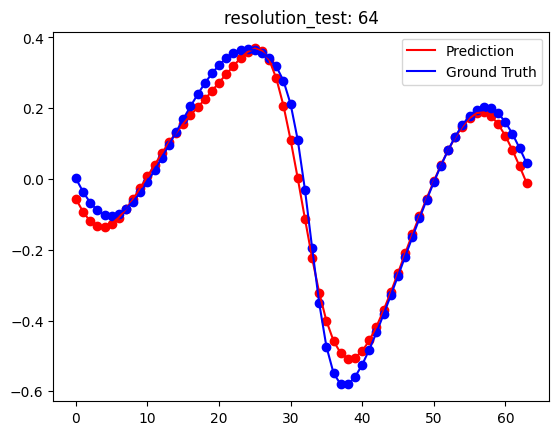

[Test] resolution_test:  256
[Dataset] downsampled raw data - x_data: torch.Size([2048, 256]), y_data: torch.Size([2048, 256])
[Dataset] x_train: torch.Size([1000, 256]), y_train: torch.Size([1000, 256])
[Dataset] x_test: torch.Size([200, 256]), y_test: torch.Size([200, 256])


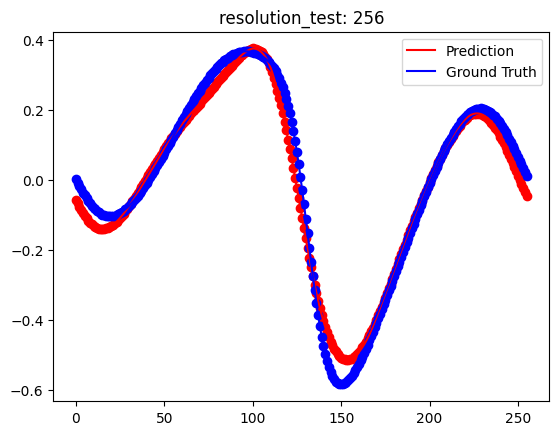

[Test] resolution_test:  1024
[Dataset] downsampled raw data - x_data: torch.Size([2048, 1024]), y_data: torch.Size([2048, 1024])
[Dataset] x_train: torch.Size([1000, 1024]), y_train: torch.Size([1000, 1024])
[Dataset] x_test: torch.Size([200, 1024]), y_test: torch.Size([200, 1024])


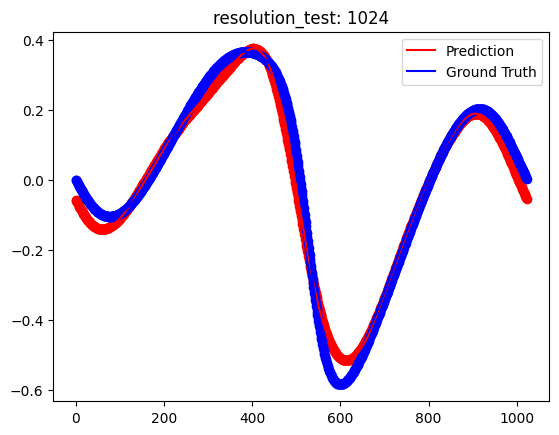

In [23]:
# train the model
model = PlModel(cfg)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath=cfg.checkpoint_dir,
    filename='fno-{epoch:02d}-{val_loss:.2f}',
    save_top_k=1,
    mode='min',
)

trainer = pl.Trainer(
    max_epochs=cfg.num_epoch,
    callbacks=[checkpoint_callback],
    accelerator='gpu',
    devices=1,
    enable_progress_bar=False,
)
trainer.fit(model, data_module)

trainer.test(model, data_module.test_dataloader())

# Evaluate the model at different resolutions
raw_data = loadmat(cfg.dataset_path)  # Ensure this is loaded correctly
resolution_test_list = [64, 256, 1024]
model.evaluate_at_different_resolutions(raw_data, resolution_test_list)

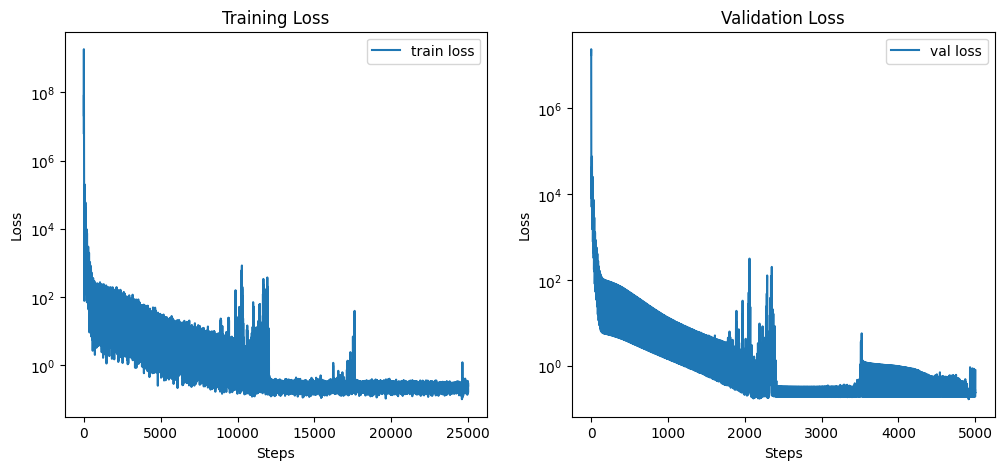

In [21]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(model.metrics['train_loss'], label='train loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model.metrics['val_loss'], label='val loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Validation Loss')
plt.legend()
plt.show()